In [1]:
using LinearAlgebra  #####Son las paqueterias que uso, para instalar una paqueteria basta colocar Pkg.add("Nombre_de_la_paqueteria")
using Plots
using SpecialFunctions: gamma
using Random, Distributions

In [2]:
function OUH(x0::Float64,γ::Float64,t::AbstractArray,Δt::Float64,η::Float64,cte::Float64=0.0) #Proceso de Ornstein–Uhlenbeck
    x=Vector{Float64}(undef, length(t)) #Definimos un vector lleno de basura para luego sobre escribir en el 
    x[1]=x0    #La primera entrada es la condicion inicial del Proceso de Ornstein–Uhlenbeck
    
    for i=1:length(t)                 #Usamos un for para poder hacer el proceso
        x0=x0-γ*Δt*(x0-cte)+(η*sqrt(Δt)*randn()) # Es el proceso de Ornstein–Uhlenbeck que depende del paso anterior 
        @inbounds x[1+i]=x0                 #@inbounds ignora si la lista tiene el tamaño adecuado y sobreescribimos en la lista basura
    end
    return x                          # Devolvemos la caminata de Ornstein–Uhlenbeck
end

OUH (generic function with 2 methods)

In [3]:
function eigen2(n::Int64,Δt::Float64,K::Array{Float64,1}) #Obtenemos los eigenvalores y eigenvectores 
    R=diagm(0 =>ones(2))                                #Hacemos una matriz llena de unos en la diagonal de dimension 2
    for i=1:n                                           #Hacemos un for donde n es la cantidad de pasos de t, pasos de tiempo
       R=(diagm(0 => ones(2))+diagm(1 => [K[i]]*Δt,-1 => -[K[i]]*Δt)+(0.5*diagm(1 => [K[i]]*Δt,-1 => -[K[i]]*Δt)^2))*R #Hacemos los pasos de multiplicar la matriz por la matriz anterior 
    end
    eigen(R)#Obtenemos el eigenvalor y eigenvector
end

function eigen2(n::Int64,Δt::Float64,K::Array{Float64,1},T::Array{Float64,1}) 
    R=diagm(0 =>ones(3)) #Hacemos una matriz llena de unos en la diagonal de dimension 2
    for i=1:n            #Hacemos un for donde n es la cantidad de pasos de t, pasos de tiempo
       R=(diagm(0 => ones(3))+diagm(1 => [K[i],T[i]]*Δt,-1 => -[K[i],T[i]]*Δt)+(0.5*diagm(1 => [K[i],T[i]]*Δt,-1 => -[K[i],T[i]]*Δt)^2))*R #Hacemos los pasos de multiplicar la matriz por la matriz anterior 
    end
    eigen(R) #Obtenemos el eigenvalor y eigenvector
end

eigen2 (generic function with 2 methods)

In [4]:
function lam_eigenvals(γK::Float64,Δt::Float64,t::AbstractArray,tiradas::Int64,ηK::Float64,k0::Float64,ctek::Float64=0.0) #Da una lista de eigenvalores de todas las tiradas
    λ=Vector{Complex{Float64}}(undef,2*tiradas) #Nos hace una lista llena de basura para renombrar sus valores
    for i=1:tiradas             #Un for con la cantidad de tiradas
        K=OUH(k0,γK,t,Δt,ηK,ctek)        #Usamos el proceso de Ornstein–Uhlenbeck para cada tirada
        a=eigen2(length(t),Δt,K).values #Obtenemos los eigenvalores de cada tirada
        @inbounds λ[2*i-1]=a[1] #Reescribirmos la basura con los eigenvalores
        @inbounds λ[2*i-0]=a[2] #Reescribirmos la basura con los eigenvalores
    end
    return λ   #Devolvemos la lista de eigenvalores
end

function lam_eigenvals(γ::Array{Float64,1},Δt::Float64,t::AbstractArray,tiradas::Int64,η::Array{Float64,1},x0::Array{Float64,1},cte::Array{Float64,1}=[0.0,0.0])
    λ=Vector{Complex{Float64}}(undef,3*tiradas) #Nos hace una lista llena de basura para renombrar sus valores
    for i=1:tiradas #Un for con la cantidad de tiradas
        K=OUH(x0[1],γ[1],t,Δt,η[1],cte[1]) #Usamos el proceso de Ornstein–Uhlenbeck para cada tirada
        T=OUH(x0[2],γ[2],t,Δt,η[2],cte[2]) #Usamos el proceso de Ornstein–Uhlenbeck para cada tirada
        a=eigen2(length(t),Δt,K,T).values #Obtenemos los eigenvalores de cada tirada
        @inbounds λ[3*i-2]=a[1] #Reescribirmos la basura con los eigenvalores
        @inbounds λ[3*i-1]=a[2] #Reescribirmos la basura con los eigenvalores
        @inbounds λ[3*i-0]=a[3] #Reescribirmos la basura con los eigenvalores
    end
    return λ
end

lam_eigenvals (generic function with 4 methods)

In [5]:
function lam_eigenvals_C(λ::Array{Complex{Float64},1})
    λr=Complex{Float64}[]
    for i=1:length(λ)
        if imag(λ[i]) != 0
            push!(λr,λ[i])
        end
    end
    return λr
end
function lam_eigenvals_R(λ::Array{Complex{Float64},1})
    λr=Float64[]
    for i=1:length(λ)
        if imag(λ[i]) == 0
            push!(λr,λ[i])
        end
    end
    return λr
end

lam_eigenvals_R (generic function with 1 method)

In [6]:
function ev_vector_eje(n::Int64,Δt::Float64,K::Array{Float64,1},T::Array{Float64,1})
    v=Array{Float64,1}[]
    for j=1:n
        for i=1:3
            a=imag.(vec((eigen2(j,Δt,K,T).vectors)[i:i, 1:3]))
            if a==[0.0,0.0,0.0]
                push!(v,real.(vec((eigen2(j,Δt,K,T).vectors)[i:i, 1:3])))
            end
        end
    end
    return v
end


function vector_eje_en_TiempoN(paso::Int64,tiradas::Int64,t::AbstractArray,Δt::Float64,k0::Float64,γK::Float64,ηK::Float64,ctek::Float64,t0::Float64,γT::Float64,ηT::Float64,ctet::Float64)
    v=Array{Float64,1}[]
    for j=1:tiradas
        K=OUH(k0,γK,t,Δt,ηK,ctek)
        T=OUH(t0,γT,t,Δt,ηT,ctet)
        for i=1:3
            a=imag.(vec((eigen2(paso,Δt,K,T).vectors)[i:i, 1:3]))
            if a==[0.0,0.0,0.0]
                push!(v,real.(vec((eigen2(paso,Δt,K,T).vectors)[i:i, 1:3])))
            end
        end
    end
    return v
end

vector_eje_en_TiempoN (generic function with 1 method)

In [7]:
k0=0.0
t0=0.0

γK=1.0
γT=1.0

ηK=1.0
ηT=1.0

Δt=0.001

N=10.0

t=0:Δt:N

ctek=0.0
ctet=0.0

#para animar
tiradas=1000
step=100
length(1:step:length(t))


101

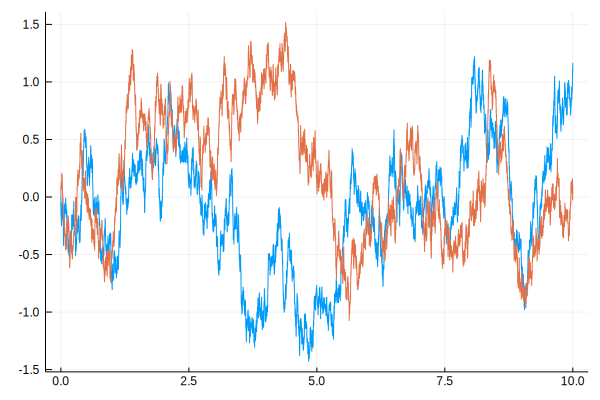

In [8]:

plot(t,OUH(k0,γK,t,Δt,ηK,ctek),legend=false)
plot!(t,OUH(t0,γT,t,Δt,ηT,ctet),legend=false)

In [9]:
@time λ_2=lam_eigenvals(γK,Δt,t,tiradas,ηK,k0,ctek);


120.809769 seconds (516.55 M allocations: 25.269 GiB, 4.77% gc time)


In [10]:
@time λ_3=lam_eigenvals([γK,γT],Δt,t,tiradas,[ηK,ηT],[k0,t0],[ctek,ctet]);

128.455541 seconds (630.30 M allocations: 30.119 GiB, 6.17% gc time)


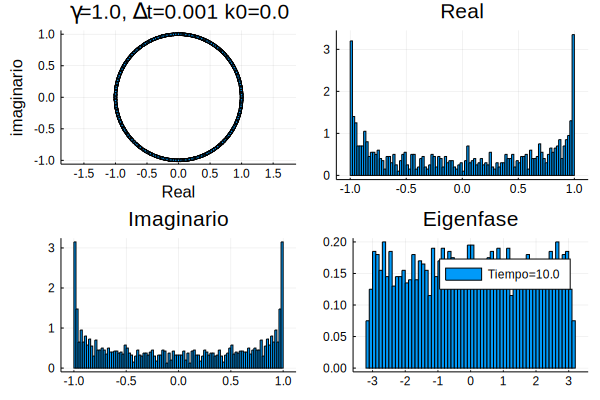

In [11]:
l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
Q1=scatter(real(λ_2),imag(λ_2),legend=false,aspect_ratio=:equal,markersize=1,xlabel="Real",ylabel="imaginario",title="\\gamma=$γK, \\Deltat=$(Δt) k0=$(k0)")
Q2=histogram(real(λ_2),normalized=true,title="Real",legend=false,bins=100)
Q3=histogram(imag(λ_2),normalized=true,title="Imaginario",legend=false,bins=100)
Q4=histogram(angle.(λ_2),normalized=true,bins=60,label="Tiempo=$(N)",title="Eigenfase")
plot(Q1,Q2,Q3,Q4,layout=l)
#savefig("Eigenvalores_Completo_2D_gam=$(γ)_k0=$(k0).png")

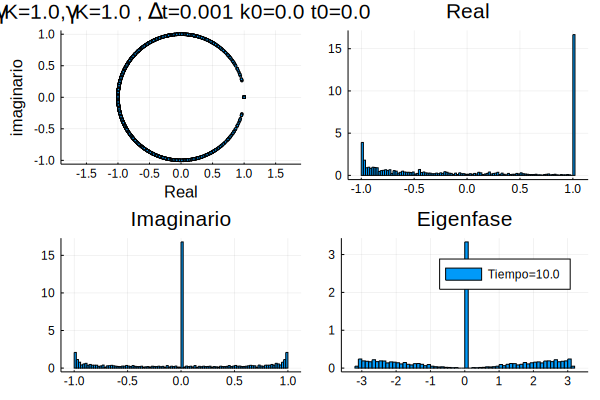

In [12]:

l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
Q1=scatter(real(λ_3),imag(λ_3),legend=false,aspect_ratio=:equal,markersize=1,xlabel="Real",ylabel="imaginario",title="\\gammaK=$γT,\\gammaK=$γT , \\Deltat=$(Δt) k0=$(k0) t0=$(t0)")
Q2=histogram(real(λ_3),normalized=true,title="Real",legend=false,bins=100)
Q3=histogram(imag(λ_3),normalized=true,title="Imaginario",legend=false,bins=100)
Q4=histogram(angle.(λ_3),normalized=true,bins=60,label="Tiempo=$(N)",title="Eigenfase")
plot(Q1,Q2,Q3,Q4,layout=l)
#savefig("Eigenvalores_Completo_3D_gam=$(γ)_k0=$(k0)_t0=$(t0).png")

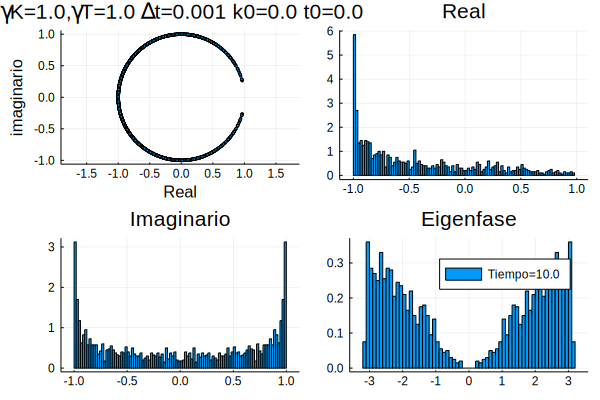

In [13]:
λ_3_C=lam_eigenvals_C(λ_3)
l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
Q1=scatter(real(λ_3_C),imag(λ_3_C),legend=false,aspect_ratio=:equal,markersize=1,xlabel="Real",ylabel="imaginario",title="\\gammaK=$γT,\\gammaT=$γT \\Deltat=$(Δt) k0=$(k0) t0=$(t0)")
Q2=histogram(real(λ_3_C),normalized=true,title="Real",legend=false,bins=100)
Q3=histogram(imag(λ_3_C),normalized=true,title="Imaginario",legend=false,bins=100)
Q4=histogram(angle.(λ_3_C),normalized=true,bins=60,label="Tiempo=$(N)",title="Eigenfase")
plot(Q1,Q2,Q3,Q4,layout=l)
#savefig("Eigenvalores_Completo_3D_Complejo_gam=$(γ)_k0=$(k0)_t0=$(t0).png")

In [14]:
λ_3_R=lam_eigenvals_R(λ_3)
l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
Q1=scatter(real(λ_3_R),imag(λ_3_R),legend=false,aspect_ratio=:equal,markersize=1,xlabel="Real",ylabel="imaginario",title="\\gammaK=$γT,\\gammaT=$γT, \\Deltat=$(Δt) k0=$(k0) t0=$(t0)")
Q2=histogram(real(λ_3_R),normalized=true,title="Real",legend=false,bins=100)
Q3=histogram(imag(λ_3_R),normalized=true,title="Imaginario",legend=false,bins=100)
Q4=histogram(angle.(λ_3_R),normalized=true,bins=60,label="Tiempo=$(N)",title="Eigenfase")
plot(Q1,Q2,Q3,Q4,layout=l)
savefig("Eigenvalores_Completo_3D_Reales_gamK=$(γK)_gamT=$(γT)_k0=$(k0)_t0=$(t0).png")

In [ ]:
@time begin    
    anim= @animate for j=2:step:length(t)
        λ=lam_eigenvals(γK,Δt,t[1:j],tiradas,ηK,k0,ctek);
        l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
        Q3=histogram(imag(λ),normalized=true,title="Imaginario",legend=false,bins=100,xlims=(-5.1,5.1),ylims=(0,15.5))
        Q2=histogram(real(λ),normalized=true,title="Real",legend=false,bins=100,xlims=(-5.1,5.1),ylims=(0,12.2))
        Q1=scatter(real(λ),imag(λ),legend=false,aspect_ratio=:equal,markersize=1,xlabel="Real",ylabel="imaginario",title="\\gammaK=$γK, \\Deltat=$(Δt) k0=$(k0)",xlims=(-5.1,5.1),ylims=(-5.1,5.1))
        #Q4=histogram(abs.(λ),normalized=true,bins=60,label="Tiempo=$(t[j])",title="Norma",xlims=(1.000,1.0034))
        Q4=histogram(angle.(λ),normalized=true,bins=60,label="Tiempo=$(t[j])",title="Eigenfase",xlims=(-(π+0.2),π+0.2),ylims=(0,1.5))
        plot(Q1,Q2,Q3,Q4,layout=l)
    end
    gif(anim,"./Animacion_Prueba_2D_k0=$(k0).gif", fps=60)
end

In [ ]:
@time begin    
    anim= @animate for j=2:step:length(t)
        λ=lam_eigenvals_C(lam_eigenvals([γK,γT],Δt,t[1:j],tiradas,[ηK,ηT],[k0,t0],[ctek,ctet]));
        l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
        Q3=histogram(imag(λ),normalized=true,title="Imaginario",legend=false,bins=100,xlims=(-5.1,1.1),ylims=(0,15.5))
        Q2=histogram(real(λ),normalized=true,title="Real",legend=false,bins=100,xlims=(-5.1,1.1),ylims=(0,12.2))
        Q1=scatter(real(λ),imag(λ),legend=false,aspect_ratio=:equal,markersize=1,xlabel="Real",ylabel="imaginario",title="\\gammaK=$γK,\\gammaT=$γT, \\Deltat=$(Δt) k0=$(k0) t0=$(t0)",xlims=(-5.1,5.1),ylims=(-5.1,5.1))
        #Q4=histogram(abs.(λ),normalized=true,bins=60,label="Tiempo=$(t[j])",title="Norma",xlims=(1.000,1.0034))
        Q4=histogram(angle.(λ),normalized=true,bins=60,label="Tiempo=$(t[j])",title="Eigenfase",xlims=(-(π+0.2),π+0.2),ylims=(0,1.5))
        plot(Q1,Q2,Q3,Q4,layout=l)
    end
    gif(anim,"./Animacion_Prueba_3D_gamK=$(γK)_gamT=$(γT)_k0=$(k0)_t0=$(t0)_no_reals.gif", fps=60)
end

In [ ]:
paso=10
v=vector_eje_en_TiempoN(paso,tiradas,t,Δt,k0,γK,ηK,ctek,t0,γT,ηT,ctet);

In [ ]:
histogram(transpose(hcat(v...))[:,3], bins=50)

In [ ]:
scatter3d(transpose(hcat(v...))[:,1],transpose(hcat(v...))[:,2],transpose(hcat(v...))[:,3],
    xlims=(-1,1),ylims=(-1,1),zlims=(-1,1)
    ,camera = (20,50))

In [ ]:
scatter(transpose(hcat(v...))[:,1],transpose(hcat(v...))[:,2],xlims=(-1,1),ylims=(-1,1))

In [437]:
K=OUH(k0,γK,t,Δt,DtK,ctek)
T=OUH(t0,γT,t,Δt,DtT,ctet);
ve=ev_vector_eje(length(t),Δt,K,T);

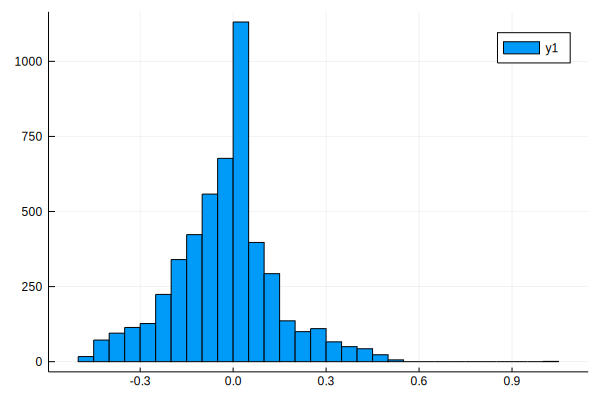

In [438]:

histogram(transpose(hcat(ve...))[:,3], bins=50)

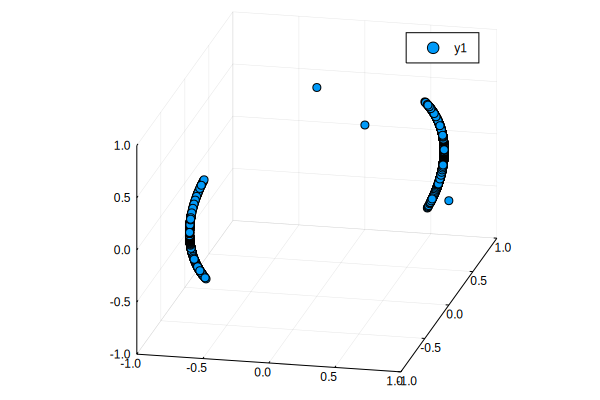

In [439]:
scatter3d(transpose(hcat(ve...))[:,1],transpose(hcat(ve...))[:,2],transpose(hcat(ve...))[:,3],
    xlims=(-1,1),ylims=(-1,1),zlims=(-1,1)
    ,camera = (20,50)
    ,aspect_ratio=:equal)

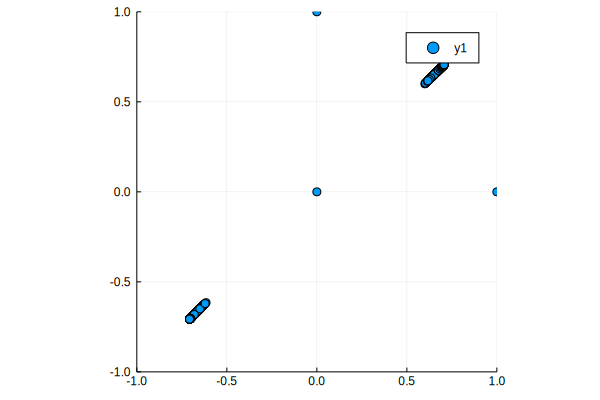

In [440]:
scatter(transpose(hcat(ve...))[:,1],transpose(hcat(ve...))[:,2],xlims=(-1,1),ylims=(-1,1)
    ,aspect_ratio=:equal)

In [129]:
an

3-element Array{Float64,1}:
 -2.3222827886191504
  2.3222827886191504
  0.0               

In [193]:
angle(cos(3*π/2)+im*sin(3*π/2))

-1.570796326794897

In [157]:
π/2

1.5707963267948966

-20.0:0.1:20.0

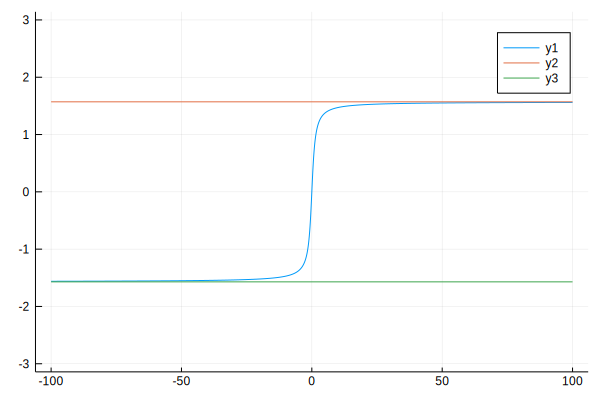

In [186]:
x=-100:0.1:100
plot(x,atan.(x),ylims=(-π,π))
plot!(x,ones(length(x))*π/2)
plot!(x,ones(length(x))*-π/2)

In [174]:
atan2(sin(3*π/2), cos(3*π/2))

UndefVarError: UndefVarError: atan2 not defined

In [173]:
methods(angle)

# 2 methods for generic function "angle":
[1] angle(z::Real) in Base at number.jl:194
[2] angle(z::Complex) in Base at complex.jl:557

In [35]:
Δt=0.001
K=0.5
T=0.5
(diagm(0 => ones(3))+diagm(1 => [K,T]*Δt,-1 => -[K,T]*Δt)+(0.5*diagm(1 => [K,T]*Δt,-1 => -[K,T]*Δt)^2))

3×3 Array{Float64,2}:
  1.0       0.0005  1.25e-7
 -0.0005    1.0     0.0005 
  1.25e-7  -0.0005  1.0    

In [93]:
exp(diagm(1 => [K,T]*Δt,-1 => -[K,T]*Δt))

3×3 Array{Float64,2}:
  1.0       0.0005  1.25e-7
 -0.0005    1.0     0.0005 
  1.25e-7  -0.0005  1.0    

In [95]:
angle.(λ_2)

1500-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮  
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [534]:
K=OUH(k0,γ,t,Δt,Dt,ctek)
T=OUH(t0,γ,t,Δt,Dt,ctet);
v=ev_vector_eje(length(t),K,T);

In [539]:
paso=100
tiradas=500
DtK=Dt
DtT=Dt
γK=γ
γT=γ
v=vector_eje_en_TiempoN(paso,tiradas,t,Δt,k0,γK,DtK,ctek,t0,γT,DtT,ctet);


In [488]:
v=Array{Float64,1}[]
paso=10
for j=1:500
    K=OUH(k0,γK,t,Δt,DtK,ctek)
    T=OUH(t0,γT,t,Δt,DtT,ctet)
    for i=1:3
        a=imag.(vec((eigen2(paso,Δt,K,T).vectors)[i:i, 1:3]))
        if a==[0.0,0.0,0.0]
            push!(v,real.(vec((eigen2(paso,Δt,K,T).vectors)[i:i, 1:3])))
        end
    end
end

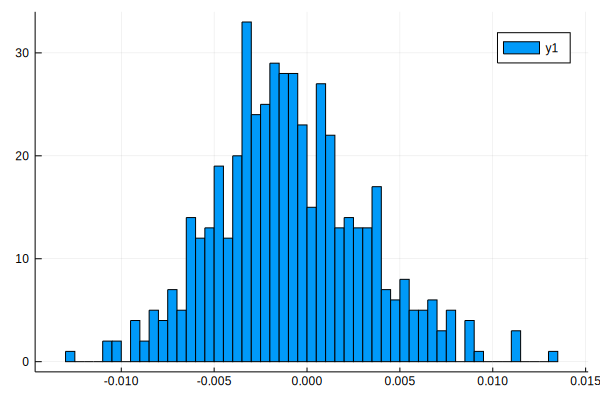

In [543]:
histogram(transpose(hcat(v...))[:,3], bins=50)

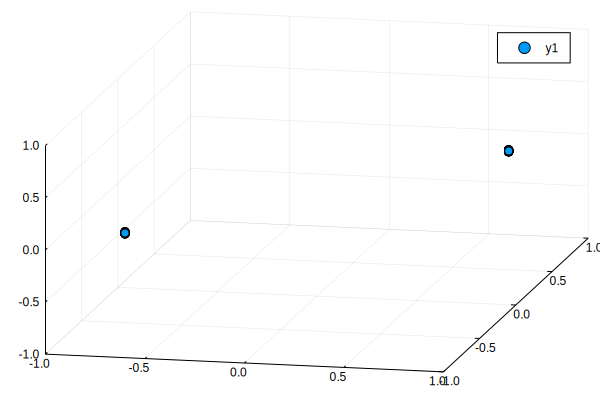

In [544]:
scatter3d(transpose(hcat(v...))[:,1],transpose(hcat(v...))[:,2],transpose(hcat(v...))[:,3],
    xlims=(-1,1),ylims=(-1,1),zlims=(-1,1)
    ,camera = (20,50))

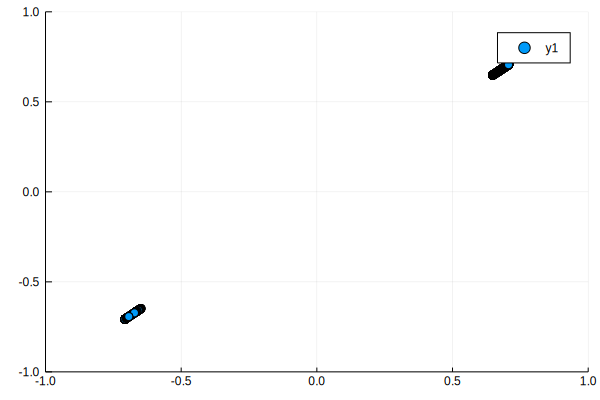

In [533]:
scatter(transpose(hcat(v...))[:,1],transpose(hcat(v...))[:,2],xlims=(-1,1),ylims=(-1,1))

In [282]:
v=Array{Complex{Float64},1}[]

0-element Array{Array{Complex{Float64},1},1}

In [348]:
push!(v,vec((eigen2(length(t),Δt,K,T).vectors)[1:1, 1:3]))

6002-element Array{Array{Complex{Float64},1},1}:
 [0.7071067811865555 + 0.0im, 0.7071067811865555 + 0.0im, 2.3609410045835665e-15 + 0.0im]                                 
 [0.7071067811583529 + 0.0im, 0.7071067811583529 + 0.0im, -8.929843612259536e-6 + 0.0im]                                  
 [-0.707106781047457 + 0.0im, -0.707106781047457 + 0.0im, -1.9834562336192727e-5 + 0.0im]                                 
 [0.7071067811401 + 0.0im, 0.7071067811401 + 0.0im, -1.1461780110180126e-5 + 0.0im]                                       
 [0.7071067811217036 + 0.0im, 0.7071067811217036 + 0.0im, -1.3542825284425722e-5 + 0.0im]                                 
 [0.7071067811544964 + 0.0im, 0.7071067811544964 + 0.0im, -9.521355819216223e-6 + 0.0im]                                  
 [-0.7071067811789182 + 0.0im, -0.7071067811789182 + 0.0im, 4.645536826674822e-6 + 0.0im]                                 
 [-0.7071067810793008 + 0.0im, -0.7071067810793008 + 0.0im, 1.741658718536262e-5 + 0.0im] 

In [350]:
real.(vec((eigen2(length(t),Δt,K,T).vectors)[1:1, 1:3]))

3-element Array{Float64,1}:
  0.012248614729691618
  0.012248614729691618
 -0.9638267381588662  

In [296]:
imag.(vec((eigen2(length(t),Δt,K,T).vectors)[2:2, 1:3]))==[0.0,0.0,0.0]

true

In [226]:
[-0.0869301-0.616925im,-0.0869301-0.616925im,-0.0869301-0.616925im]

3-element Array{Complex{Float64},1}:
 -0.0869301 - 0.616925im
 -0.0869301 - 0.616925im
 -0.0869301 - 0.616925im

In [230]:
? vect()

No documentation found.

Binding `vect` does not exist.


In [204]:
x = reshape(1:16, 4, 4)

4×4 reshape(::UnitRange{Int64}, 4, 4) with eltype Int64:
 1  5   9  13
 2  6  10  14
 3  7  11  15
 4  8  12  16

In [478]:
x[2:4, 2:end-1]

3×2 Array{Int64,2}:
 6  10
 7  11
 8  12

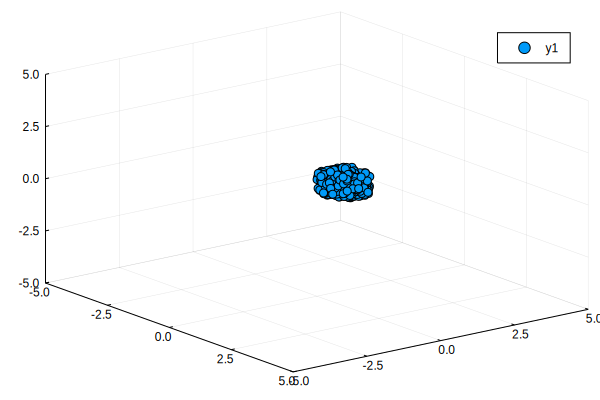

In [477]:
scatter(rand(1000),rand(1000),rand(1000),xlims=(-5,5),ylims=(-5,5),zlims=(-5,5),camera = (50,50))

In [233]:
randn()+randn()

-0.2355286865147781

In [245]:
d1 = Normal(3,1)
#Normal(μ=0.0, σ=1.0)

Normal{Float64}(μ=3.0, σ=1.0)

In [246]:
d2=Normal(-5,1)

Normal{Float64}(μ=-5.0, σ=1.0)

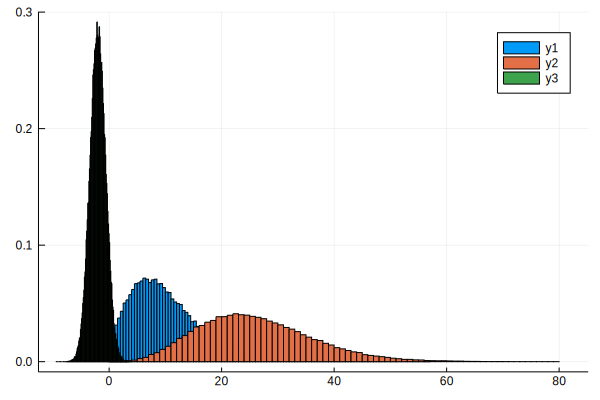

In [254]:
histogram(rand(d1,100000).^2,normalize=true)
histogram!(rand(d2,100000).^2,normalize=true)
histogram!(rand(d2,100000)+rand(d1,100000),normalize=true)

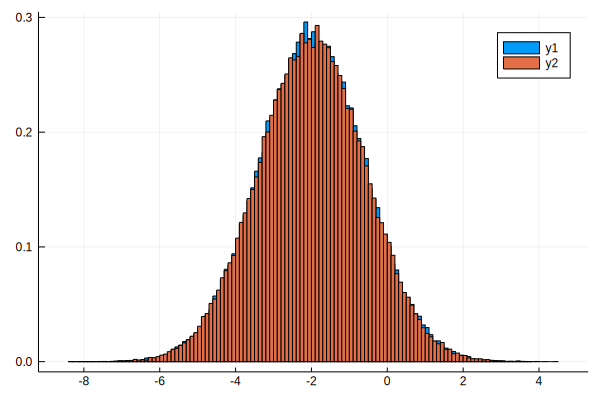

In [288]:
histogram(rand(Normal(-2,1.4),100000),normalize=true)
histogram!(rand(d2,100000)+rand(d1,100000),normalize=true)
#histogram!(rand(Normal(-2,1),100000),normalize=true)


In [378]:
mean((rand(d1,100000).^(2)+rand(d2,100000).^(2)).^0.5)

5.917511659198123

In [312]:
var(rand(Normal(0,2),10000000))

4.000324101244383

In [275]:
var(rand(Normal(-2,2),100000))

3.9817228938590605

In [291]:
Normal(0,2)

Normal{Float64}(μ=0.0, σ=2.0)

In [302]:
sqrt(37.7)

6.1400325732035

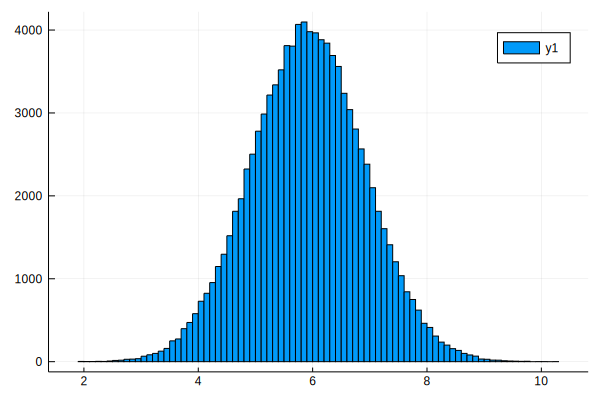

In [389]:
histogram((rand(d1,100000).^(2)+rand(d2,100000).^(2)).^0.5)

In [399]:
var((rand(d1,100000).^(2)+rand(d2,100000).^(2)).^0.5)

0.9851965496925055

In [400]:
mean((rand(d1,100000).^(2)+rand(d2,100000).^(2)).^0.5)

5.913571431153377